## Import library dan membuka dataset

In [1]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
from collections import Counter

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger
nltk.download('punkt')
nltk.download('punkt_tab')

# Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# Other
import pycrfsuite
from tqdm import tqdm
import json
import indoNLP

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Load stopwords bahasa Indonesia
nltk.download('punkt')  # Untuk tokenizer
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Membaca dataset, mengabaikan line yang tidak perlu
column_names = ['video_id', 'judul_video', 'timestamp_video', "komentar", "timestamp_komentar"]

data = pd.read_csv('youtube_data.csv', on_bad_lines='skip', names=column_names)

# Melihat data awal
data.head()

,video_id,judul_video,timestamp_video,komentar,timestamp_komentar
0,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Benar itu bisa membuka jln buat anak muda jad...,2024-06-05T05:12:28Z
1,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,emang ngrbmlk klarga gtauml,2024-06-03T10:36:12Z
2,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,"""Putra sulung"" ?????",2024-06-03T05:05:04Z
3,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Seharus nya batas usia 20th jadi kesempatan a...,2024-06-02T23:35:07Z
4,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Mungkin sekeluarga itu sudah di hapus dengan A...,2024-06-02T13:28:13Z


In [4]:
data['timestamp_komentar'] = pd.to_datetime(data['timestamp_komentar'])
data['timestamp_video'] = pd.to_datetime(data['timestamp_video'])

In [5]:
earliest_date = min(
    data['timestamp_komentar'].min(),
    data['timestamp_video'].min()
)

latest_date = max(
   data['timestamp_komentar'].max(),
    data['timestamp_video'].max()
)

In [6]:
print(f"Tanggal paling awal: {earliest_date}")
print(f"Tanggal paling akhir: {latest_date}")

Tanggal paling awal: 2023-09-01 16:21:36+00:00
Tanggal paling akhir: 2024-10-29 07:18:01+00:00


In [106]:
data.shape

(262607, 5)

Jumlah data ada 1.180.384 baris dengan 5 kolom fitur: id video, judul video, timestamp judul, komentar, dan timestamp komentar.

## Jumlah data yang diambil

### Jumlah komentar yang di-post per minggu

In [107]:
data.columns


Index(['video_id', 'judul_video', 'timestamp_video', 'komentar',
       'timestamp_komentar'],
      dtype='object')

In [108]:
data['timestamp_komentar'] = pd.to_datetime(data['timestamp_komentar'], errors='coerce')


In [109]:
# Filter data antara September 2023 sampai Mei 2024
data['timestamp_komentar'] = pd.to_datetime(data['timestamp_komentar'])

filtered_data = data[(data['timestamp_komentar'] >= start_filter) & (data['timestamp_komentar'] <= end_filter)]
filtered_data = filtered_data.loc[:, ['timestamp_komentar']].set_index('timestamp_komentar')
data_per_week = filtered_data.resample('W').size()


In [110]:
# Hitung jumlah data yang dikumpulkan per minggu
data_per_week = filtered_data.resample('W').size()

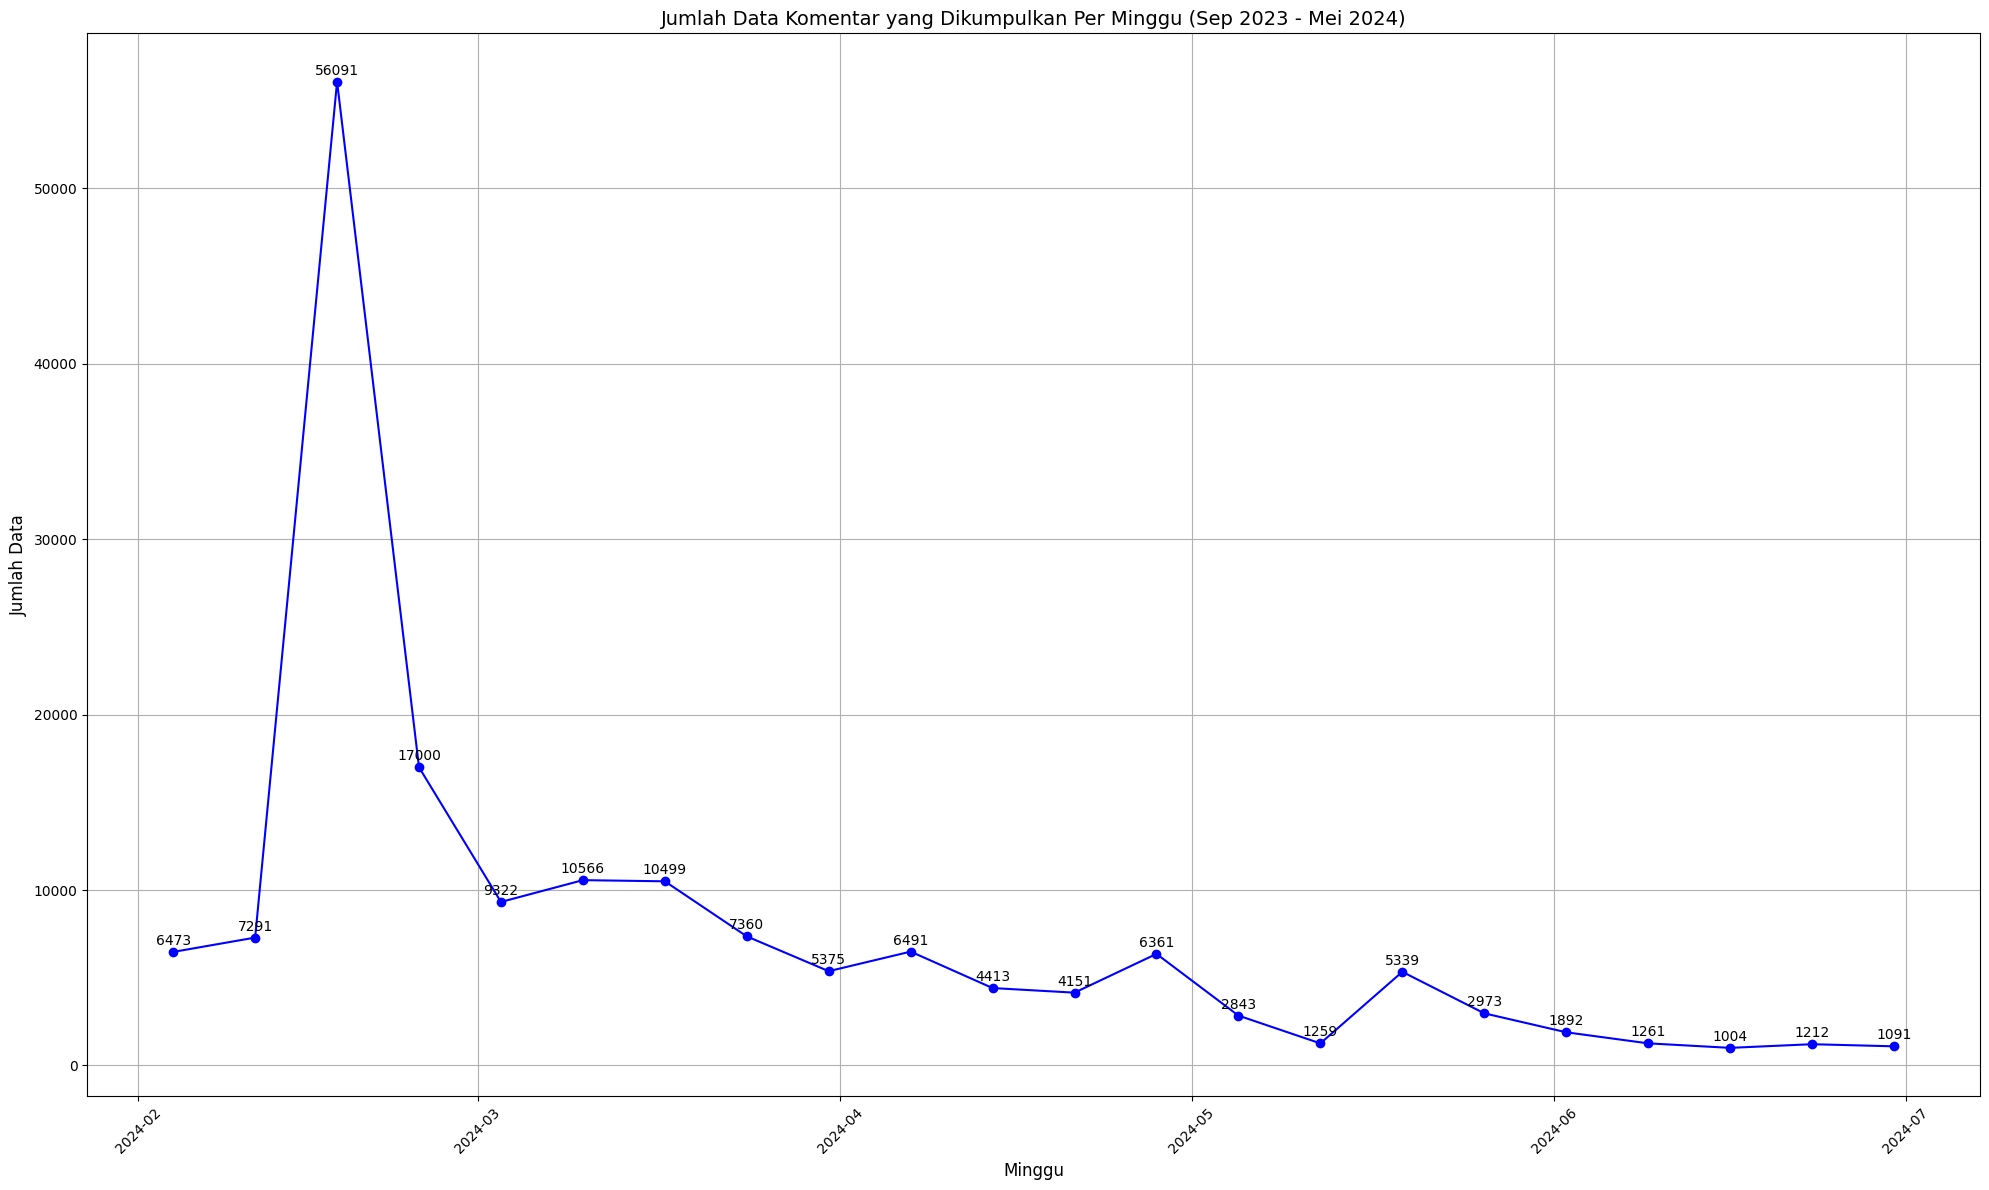

In [111]:
# Plot jumlah data yang dikumpulkan per minggu menggunakan Line Chart
plt.figure(figsize=(20,12))
plt.plot(data_per_week.index, data_per_week.values, marker='o', linestyle='-', color='b')  # Line chart

# Menambahkan judul dan label
plt.title('Jumlah Data Komentar yang Dikumpulkan Per Minggu (Sep 2023 - Mei 2024)', fontsize=14)
plt.xlabel('Minggu', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)

# Menambahkan label pada setiap titik
for i, value in enumerate(data_per_week.values):
    plt.annotate(str(value), (data_per_week.index[i], data_per_week.values[i]),
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

# Membuat grid
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan plot
plt.show()

           date  jumlah_komentar
0    2023-09-01               38
1    2023-09-02               27
2    2023-09-03               49
3    2023-09-04               23
4    2023-09-05               10
..          ...              ...
420  2024-10-25              258
421  2024-10-26              232
422  2024-10-27              280
423  2024-10-28              247
424  2024-10-29               55

[425 rows x 2 columns]


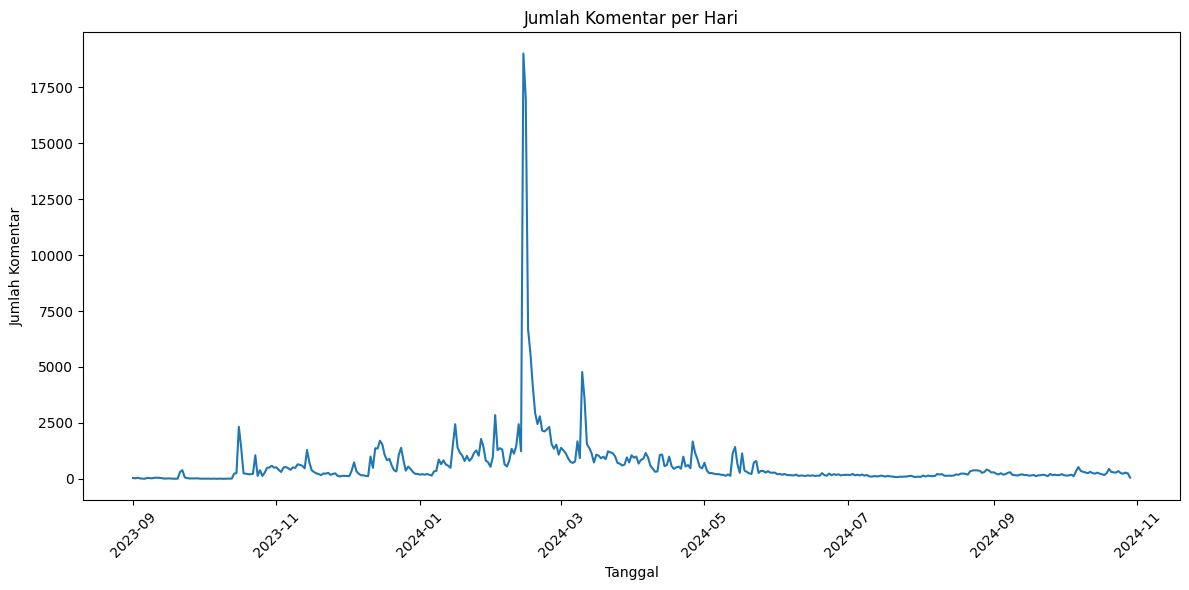

In [9]:
data['timestamp_komentar'] = pd.to_datetime(data['timestamp_komentar'])

data['date'] = data['timestamp_komentar'].dt.date

comments_per_day= data.groupby('date').size().reset_index(name='jumlah_komentar')

comments_per_day = comments_per_day.sort_values('date')

print(comments_per_day)


plt.figure(figsize=(12,6))
plt.plot(comments_per_day['date'], comments_per_day['jumlah_komentar'])
plt.title('Jumlah Komentar per Hari')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Preprocessing

## Menghilangkan komentar kosong

In [112]:
# cek null value
data.isnull().sum()

# Menghapus data yang memiliki nilai null
data.dropna(inplace=False)

,video_id,judul_video,timestamp_video,komentar,timestamp_komentar
0,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Benar itu bisa membuka jln buat anak muda jad...,2024-06-05 05:12:28+00:00
1,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,emang ngrbmlk klarga gtauml,2024-06-03 10:36:12+00:00
2,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,"""Putra sulung"" ?????",2024-06-03 05:05:04+00:00
3,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Seharus nya batas usia 20th jadi kesempatan a...,2024-06-02 23:35:07+00:00
4,gZohqX66RKo,Reaksi Jokowi dan Gibran MA Ubah Syarat Umur C...,2024-05-31T04:09:12Z,Mungkin sekeluarga itu sudah di hapus dengan A...,2024-06-02 13:28:13+00:00
...,...,...,...,...,...
262602,5je00g6OURQ,Alasan Masyarakat Puas Atas Putusan MK di Seng...,2024-04-30T06:14:40Z,🤭,2024-04-30 09:21:26+00:00
262603,5je00g6OURQ,Alasan Masyarakat Puas Atas Putusan MK di Seng...,2024-04-30T06:14:40Z,Udeh dari zaman zebot klu kalah banjak alasan ...,2024-04-30 07:18:02+00:00
262604,5je00g6OURQ,Alasan Masyarakat Puas Atas Putusan MK di Seng...,2024-04-30T06:14:40Z,"Jokowi kan hobi curang pada thn 2014, 2019, da...",2024-04-30 06:46:14+00:00
262605,5je00g6OURQ,Alasan Masyarakat Puas Atas Putusan MK di Seng...,2024-04-30T06:14:40Z,Berarti 70 % rakyat indonesia senang curang ...,2024-04-30 06:43:57+00:00


In [113]:
data.isnull().sum()

video_id               0
judul_video            0
timestamp_video        0
komentar              40
timestamp_komentar     0
dtype: int64

## Menghilangkan data duplikat berdasarkan judul video dan komentar

In [114]:
# mengeecek duplikat berdasarkan judul video dan komentar
data.duplicated(subset=['judul_video', 'komentar']).sum()

68712

In [115]:
# menghilangkan data duplikat
data.drop_duplicates(subset=['judul_video', 'komentar'], inplace=True)

### Function untuk melakukan normalisasi data

In [116]:
def normalize_comments(text):
    if not isinstance(text, str):
        return text  
    # hapus emoji
    text = ''.join(c for c in text if c not in emoji.EMOJI_DATA)

    # Buat text menjadi lower case
    text = text.lower()
    

    # Bersihkan teks dari karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)

    # Bersihkan karakter yang berulang
    normal_regex = re.compile(r"(.)\1{1,}") # compiling regex pattern for a repeating character in a word (e.g., haiiii -> 'i' is repeated several times)
    text = normal_regex.sub(r"\1\1", text) # removing the repeating characters 
    
    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()


    return text

### Normalisasi: Implementasi fungsi `normalize_comments`

In [117]:
results = []

for index, row in data.iterrows():
    normalized = {}
    normalized['komentar'] = normalize_comments(row['komentar'])
    normalized['timestamp_video'] = row['timestamp_video']
    normalized['timestamp_komentar'] = row['timestamp_komentar']
    results.append(normalized) 

normalized_data = pd.DataFrame(results)

In [118]:
normalized_data.head()


,komentar,timestamp_video,timestamp_komentar
0,benar itu bisa membuka jln buat anak muda jadi...,2024-05-31T04:09:12Z,2024-06-05 05:12:28+00:00
1,emang ngrbmlk klarga gtauml,2024-05-31T04:09:12Z,2024-06-03 10:36:12+00:00
2,putra sulung,2024-05-31T04:09:12Z,2024-06-03 05:05:04+00:00
3,seharus nya batas usia 20th jadi kesempatan an...,2024-05-31T04:09:12Z,2024-06-02 23:35:07+00:00
4,mungkin sekeluarga itu sudah di hapus dengan a...,2024-05-31T04:09:12Z,2024-06-02 13:28:13+00:00


In [119]:
import os

# membuat directory untuk menyimpan dataset setelah preprocessing
os.makedirs('csv_data', exist_ok=True)

In [120]:
export_csv = normalized_data.to_csv('csv_data/normalized_data.csv', index=None, header=False)


### Standarisasi kata

In [121]:

# Memuat daftar kata singkatan slang words dari
# link: https://github.com/louisowen6/NLP_bahasa_resources/blob/master/combined_slang_words.txt
def load_dict_from_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        dictionary = json.load(file)
    return dictionary

# Usage
my_dict = load_dict_from_json_file('combined_slang_words.txt')
my_dict

{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [122]:
# ubah kata slang menjadi kata formal
def normalize_slang_words(text, slang_words_dict=my_dict):
    words = text.split()
    standarized_words = []
    for word in words:
        standarized_word = slang_words_dict.get(word, word) # Mengembalikan kata asli jika kata tidak ditemukan dalam dict 
        standarized_words.append(standarized_word)
    return ' '.join(standarized_words)

# Normalisasi kata slang
results_standardize = []

for index, row in normalized_data.iterrows():
    standarized = {}
    kata = []
    
    if not isinstance(row['komentar'], str):
       standarized['komentar'] = row['komentar']
    else:
        for word in row['komentar'].split():
            kata.append(normalize_slang_words(word))
        standarized['komentar'] = ' '.join(kata)
    
    standarized['timestamp_video'] = row['timestamp_video']
    standarized['timestamp_komentar'] = row['timestamp_komentar']
    results_standardize.append(standarized) 

standarized_data = pd.DataFrame(results_standardize)


In [123]:
standarized_data.shape

(193895, 3)

In [124]:
export_csv = standarized_data.to_csv('csv_data/standarized_data.csv', index=None, header=False)

In [125]:
standarized_data.tail(20)

,komentar,timestamp_video,timestamp_komentar
193875,didikan victoria institution kalau pasti ingge...,2024-04-05T12:23:22Z,2024-04-06 01:18:00+00:00
193876,slmat pak bekerja keras lh untk bangsa indonesia,2024-04-05T12:23:22Z,2024-04-05 14:47:46+00:00
193877,teruslah berkarir pak karyamu akan dikenang ba...,2024-04-05T12:23:22Z,2024-04-05 13:06:51+00:00
193878,siap siap posisi strategis menanti sang menantu,2023-10-23T05:02:41Z,2023-10-25 13:10:05+00:00
193879,dari semua presiden jokowi pecahkan rekor nsat...,2023-10-23T05:02:41Z,2023-10-24 05:24:02+00:00
193880,nuraninya menjawab waduh terdengar ke semua ne...,2023-10-23T05:02:41Z,2023-10-24 05:03:54+00:00
193881,mudah mudahan nanti tidak dilema,2023-10-23T05:02:41Z,2023-10-23 06:23:53+00:00
193882,gak malu bendera golkar dicopot sm org ini,2023-10-23T05:02:41Z,2023-10-23 05:08:31+00:00
193883,baca juga berita lainnya di kompas id r nputus...,2024-04-30T06:14:40Z,2024-04-30 06:34:59+00:00
193884,bagi pihak prabiwo iya puas tapi bagi pihak 01...,2024-04-30T06:14:40Z,2024-05-25 20:47:40+00:00


### Menghilangkan Stop Words

In [126]:
def remove_whitespace(text):
    if not isinstance(text, str):
        return text  
    
    return ' '.join(text.split())



In [127]:
def remove_stopwords2(text):
    if not isinstance(text, str):
        return text  
    text = remove_whitespace(text)
    stop_words = set(stopwords.words('indonesian')) 
    stop_words.update([])
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [128]:
result_remove_stopwords = []
for index, row in standarized_data.iterrows():
    removed_data = {}
    removed_data['komentar'] = remove_stopwords2(row['komentar'])
    removed_data['timestamp_video'] = row['timestamp_video']
    removed_data['timestamp_komentar'] = row['timestamp_komentar']
    result_remove_stopwords.append(removed_data) 

removed_stopwords_data = pd.DataFrame(result_remove_stopwords)

In [129]:
export_csv = removed_stopwords_data.to_csv('csv_data/removed_stopwords_data.csv', index=None, header=False)

### Stemming data

In [130]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    if not isinstance(text, str):
        return text  
    
    token = nltk.word_tokenize(text)
    stem_kalimat = []
    for k in token:
        stem_kata = stemmer.stem(k)
        stem_kalimat.append(stem_kata)

    stem_kalimat_str = ' '.join(stem_kalimat)
    return stem_kalimat_str

In [131]:
stemming_result = []
for index, row in removed_stopwords_data.iterrows():
    stemmed_data = {}
    stemmed_data['komentar'] = stemming(row['komentar'])
    stemmed_data['timestamp_video'] = row['timestamp_video']
    stemmed_data['timestamp_komentar'] = row['timestamp_komentar']
    stemming_result.append(stemmed_data) 

stemming_data = pd.DataFrame(stemming_result)

In [132]:
export_csv = stemming_data.to_csv('csv_data/stemming_data.csv', index=None, header=False)

### Check duplikat dan hapus whitespace

In [133]:
# hapus duplikat whitespace
def remove_whitespace(text):
    if not isinstance(text, str):
        return text  
    
    return ' '.join(text.split())



In [134]:
stemming_data.isnull().sum()

komentar              7
timestamp_video       0
timestamp_komentar    0
dtype: int64

In [135]:
stemming_data.dropna(inplace=True)

In [136]:
removed_whitespace_result = []
for index, row in stemming_data.iterrows():
    clean_data = {}
    clean_data['komentar'] = remove_whitespace(row['komentar'])
    clean_data['timestamp_video'] = row['timestamp_video']
    clean_data['timestamp_komentar'] = row['timestamp_komentar']
    removed_whitespace_result.append(clean_data) 

cleaned_data = pd.DataFrame(removed_whitespace_result)

In [137]:
cleaned_data

,komentar,timestamp_video,timestamp_komentar
0,buka jalan anak muda kepala daerah,2024-05-31T04:09:12Z,2024-06-05 05:12:28+00:00
1,emang ngrbmlk klarga gtauml,2024-05-31T04:09:12Z,2024-06-03 10:36:12+00:00
2,putra sulung,2024-05-31T04:09:12Z,2024-06-03 05:05:04+00:00
3,harus nya batas usia 20th sempat anak mudah pi...,2024-05-31T04:09:12Z,2024-06-02 23:35:07+00:00
4,keluarga hapus allah surga,2024-05-31T04:09:12Z,2024-06-02 13:28:13+00:00
...,...,...,...
193883,,2024-04-30T06:14:40Z,2024-04-30 09:21:26+00:00
193884,udeh zaman zebot klu kalah banjak alas duit ba...,2024-04-30T06:14:40Z,2024-04-30 07:18:02+00:00
193885,jokowi hobi curang 2014 2019 2024 3 kali jokow...,2024-04-30T06:14:40Z,2024-04-30 06:46:14+00:00
193886,70 rakyat indonesia senang curang jokowi,2024-04-30T06:14:40Z,2024-04-30 06:43:57+00:00


In [138]:
cleaned_data.duplicated(subset=['komentar']).sum()

17300

In [139]:
cleaned_data.isna().sum()

komentar              0
timestamp_video       0
timestamp_komentar    0
dtype: int64

In [140]:
cleaned_data.head()

,komentar,timestamp_video,timestamp_komentar
0,buka jalan anak muda kepala daerah,2024-05-31T04:09:12Z,2024-06-05 05:12:28+00:00
1,emang ngrbmlk klarga gtauml,2024-05-31T04:09:12Z,2024-06-03 10:36:12+00:00
2,putra sulung,2024-05-31T04:09:12Z,2024-06-03 05:05:04+00:00
3,harus nya batas usia 20th sempat anak mudah pi...,2024-05-31T04:09:12Z,2024-06-02 23:35:07+00:00
4,keluarga hapus allah surga,2024-05-31T04:09:12Z,2024-06-02 13:28:13+00:00


In [143]:
# cek data duplikat
duplcated_data = cleaned_data.duplicated(subset=['komentar'])
rows = cleaned_data[duplcated_data == True]
to_csv = rows.to_csv('csv_data/duplicated_data.csv', index=None, header=False)


In [144]:
rows

,komentar,timestamp_video,timestamp_komentar
78,,2023-10-16T15:20:21Z,2023-10-16 16:27:02+00:00
97,,2023-10-16T15:20:21Z,2023-10-16 16:08:54+00:00
179,,2024-02-10T13:15:07Z,2024-10-26 09:50:48+00:00
208,,2024-02-10T13:15:07Z,2024-10-23 08:09:44+00:00
227,,2024-02-10T13:15:07Z,2024-10-20 15:33:14+00:00
...,...,...,...
193860,mantap,2024-04-05T12:23:22Z,2024-09-10 14:24:12+00:00
193862,,2024-04-05T12:23:22Z,2024-09-02 12:14:06+00:00
193864,83,2024-04-05T12:23:22Z,2024-04-23 10:43:52+00:00
193881,pilih prabowo gibran,2024-04-30T06:14:40Z,2024-04-30 15:07:31+00:00


In [145]:
cleaned_data.drop_duplicates(subset=['komentar'], inplace=True)

In [148]:
cleaned_data.dropna(inplace=True,subset=['komentar'])

In [149]:
# hilangkan kata iya nya gak engga dg enggak
def remove_stopword_not_handled(text):
    if not isinstance(text, str):
        return text
        
    # Buat set stop words dari bahasa Indonesia
    stop_words = set(stopwords.words('indonesian'))
    
    # Update set stop_words dengan kata-kata tambahan
    stop_words.update(['iya', 'engga', 'gak', 'enggak', 'ga', 'dn', 'klu', 'klo', 'kalo', 'klo', 'nya', 'si', 'dlm', 'sih'])
    
    # Tokenisasi dan filter
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    return ' '.join(filtered_tokens)

In [150]:
cleaned_data['komentar'] = cleaned_data['komentar'].apply(remove_stopword_not_handled)

In [151]:
def normalize_slang_words(text, slang_words_dict):
    words = text.split()
    standarized_words = []
    for word in words:
        standarized_word = slang_words_dict.get(word, word) # Mengembalikan kata asli jika kata tidak ditemukan dalam dict 
        standarized_words.append(standarized_word)
    return ' '.join(standarized_words)

slangwords_collection = pd.read_csv('dict/new_kamusalay.csv', header=None, encoding='latin-1')
replacements = dict(zip(slangwords_collection[0], slangwords_collection[1])) 

cleaned_data['komentar'] = cleaned_data['komentar'].apply(lambda text: normalize_slang_words(text, replacements))

In [152]:
cleaned_data.to_csv('csv_data/cleaned_data.csv', index=None, header=False)

In [ ]:
# cleaned_data = pd.read_csv('csv_data/cleaned_data.csv', header=None, names=['komentar', 'timestamp_video', 'timestamp_komentar'])

## EDA

Word Cloud

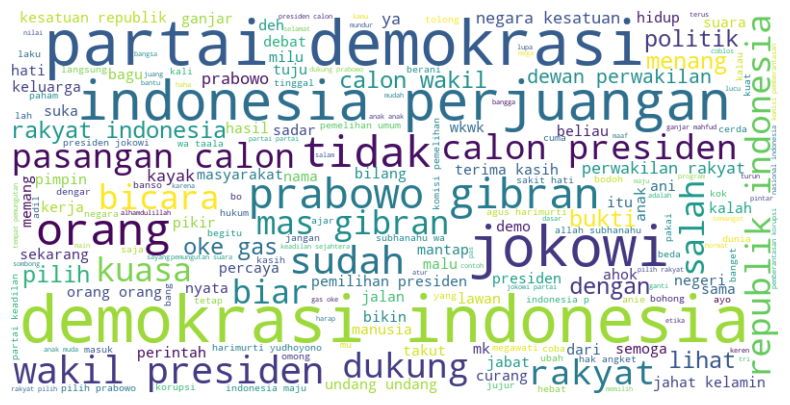

In [153]:
from wordcloud import WordCloud

# Gabungkan list token yang sudah di-stem dan dihapus stopword menjadi satu string
cleaned_data.dropna(subset=['komentar'], inplace=True)
token_data = [row.split() for row in cleaned_data['komentar']]
# gabugkan token menjadi satu string
all_words_no_stopwords = ' '.join([' '.join(tokens) for tokens in token_data])


# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_no_stopwords)

# Visualisasikan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hilangkan axis
plt.show()

#### 20 kata yang paling sering muncul

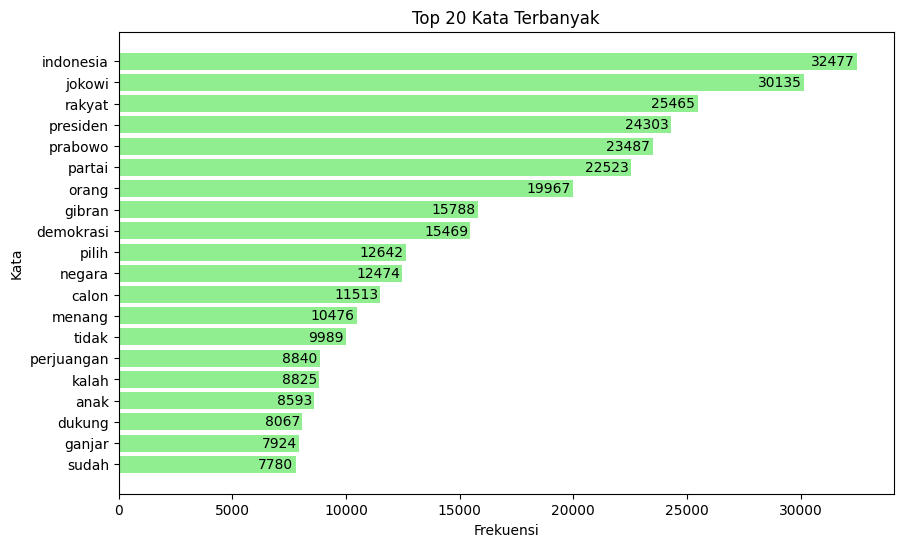

In [154]:
from collections import Counter

# Pecah string panjang menjadi list of words (tokenisasi)
token_list = all_words_no_stopwords.split()

# Hitung frekuensi kata menggunakan Counter
word_counts = Counter(token_list)

# Ambil 20 kata yang paling sering muncul
most_common_words = word_counts.most_common(20)

# Pisahkan kata dan frekuensinya untuk plotting
words, frequencies = zip(*most_common_words)

# Plot Bar Chart untuk kata-kata paling sering
plt.figure(figsize=(10, 6))
bars = plt.barh(words, frequencies, color='lightgreen')

# Menambahkan label frekuensi di dalam batang
for bar, frequency in zip(bars, frequencies):
    plt.text(bar.get_width() - 100,  # Mengatur agar teks berada sedikit di dalam batang
             bar.get_y() + bar.get_height() / 2,  # Posisi vertikal
             f'{frequency}',  # Nilai frekuensi yang akan ditampilkan
             va='center', ha='right', color='black', fontsize=10)  # Posisi dan gaya teks

# Label sumbu
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.title('Top 20 Kata Terbanyak')

# Membalik sumbu y agar kata dengan frekuensi tertinggi di atas
plt.gca().invert_yaxis()

# Tampilkan plot
plt.show()

## Sentiment Analysis

### VADER Lexicon

In [155]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


cleaned_data['neg'] = None
cleaned_data['neu'] = None
cleaned_data['pos'] = None
cleaned_data['compound'] = None

for i, row in tqdm(cleaned_data.iterrows(), total=len(cleaned_data)):
    text = row['komentar']
    if not isinstance(text, str):
        text = str(text)
    sentiment_scores = sia.polarity_scores(text)
    cleaned_data.at[i, 'neg'] = sentiment_scores['neg']
    cleaned_data.at[i, 'neu'] = sentiment_scores['neu']
    cleaned_data.at[i, 'pos'] = sentiment_scores['pos']
    cleaned_data.at[i, 'compound'] = sentiment_scores['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 176588/176588 [00:46<00:00, 3767.01it/s]


In [156]:
cleaned_data.head()


,komentar,timestamp_video,timestamp_komentar,neg,neu,pos,compound
0,buka jalan anak muda kepala daerah,2024-05-31T04:09:12Z,2024-06-05 05:12:28+00:00,0.0,1.0,0.0,0.0
1,memang ngrbmlk klarga gtauml,2024-05-31T04:09:12Z,2024-06-03 10:36:12+00:00,0.0,1.0,0.0,0.0
2,putra sulung,2024-05-31T04:09:12Z,2024-06-03 05:05:04+00:00,0.0,1.0,0.0,0.0
3,batas usia 20th anak mudah pimpin buka lebar b...,2024-05-31T04:09:12Z,2024-06-02 23:35:07+00:00,0.0,0.805,0.195,0.7003
4,keluarga hapus allah surga,2024-05-31T04:09:12Z,2024-06-02 13:28:13+00:00,0.0,1.0,0.0,0.0


In [158]:
def sentiment_group(sen):
    if sen == 0:
        return 'Neutral'
    elif sen < 0:
        return 'Negative'
    else:
        return 'Positive'

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment_category'>

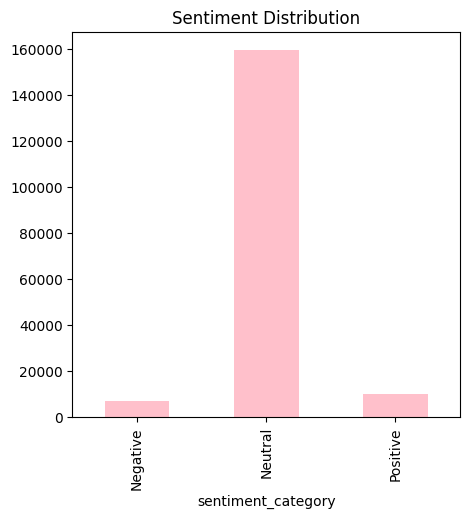

In [159]:
cleaned_data['sentiment_category'] = cleaned_data['compound'].apply(sentiment_group)

cleaned_data.groupby('sentiment_category')['komentar'].count().plot.bar(
    title='Sentiment Distribution', figsize=(5, 5), color=['pink']
)

In [162]:
import pandas as pd

def get_random_comments(data, category, num_comments=10):
    comments = data[data['sentiment_category'] == category]['komentar']
    random_comments = comments.sample(n=min(num_comments, len(comments)), random_state=1)
    return random_comments.tolist()

positive_comments = get_random_comments(cleaned_data, 'Positive')
negative_comments = get_random_comments(cleaned_data, 'Negative')
neutral_comments = get_random_comments(cleaned_data, 'Neutral')

print("Positive comments:")
for comment in positive_comments:
    print(comment)

print("\nNegative comments:")
for comment in negative_comments:
    print(comment)

print("\nNeutral comments:")
for comment in neutral_comments:
    print(comment)


Positive comments:
bagus ambil putus diantra pilih sulit mari dari titik nol clear gazz pool uang muka nkt clear sulit gazz pool berani ambil putus cepat merdekaa
2004 n1 wiranto salahuddin wahid n2 megawati soekarno putri hasyim muzadi n3 amien rais siswono yudo husodo n4 susilo bambang yudhoyono jusuf kalla n5 hamzah haz agum gumelar n2009 n1 megawati soekarno putri prabowo subianto n2 susilo bambang yudhoyono boediono n3 jusuf kalla wiranto n2014 n1 prabowo subianto hatta rajasa n2 joko widodo jusuf kalla n2019 n1 jokowi dodo maruf amin n2 prabowo subianto sandiaga uno n2024 n1 anies baswedan muhaimin iskandar n2 prabowo subianto gibran rakabuming n3 ganjar pranowo mahfud md
sudah kalah ya sok hebat di negeri
butuh makan gratis butuh lapang kerja mapan hidup layak ekonomi mapan deh mapan beli makan siang susu beli
persetan sok
weh mbelgedes susah banget kalah sok gaya pikir bangsa negara pikir kelompok
makan gratis seprei
salah adi debat2 gp serang nilai rendah play station camat de

In [166]:
for col in ['compound', 'pos', 'neu', 'neg']:
    cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')

cleaned_data = cleaned_data.dropna(subset=['compound', 'pos', 'neu', 'neg'])

### BERT (kurang lebih membuduhkan waktu 60 jam dengan NVIDA MX450)

In [67]:
# cleaned_copy = cleaned_data.copy()


In [68]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset
# from torch.utils.data import Dataset, DataLoader
# from torch.optim import AdamW


# # 1. Inisialisasi model dan tokenizer
# model_name = "indolem/indobert-base-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# # 2. Buat dataset class
# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=128):
#         self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# # 3. Fungsi untuk mengkonversi compound score ke label sentimen
# def get_sentiment_label(compound):
#     if compound >= 0.05:
#         return 2  # positive
#     elif compound <= -0.05:
#         return 0  # negative
#     else:
#         return 1  # neutral

# # 4. Persiapkan data
# def prepare_data(df):
#     # Gunakan kolom komentar sebagai teks
#     texts = df['komentar'].tolist()
    
#     # Konversi compound score ke label
#     labels = [get_sentiment_label(score) for score in df['compound']]
    
#     return train_test_split(texts, labels, test_size=0.2, random_state=42)

# # 5. Fungsi training
# def train_model(train_texts, train_labels, test_texts, test_labels):
#     # Create datasets
#     train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
#     test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

#     # Create data loaders
#     BATCH_SIZE = 8  # Reduced batch size
#     ACCUMULATION_STEPS = 2  # Original batch size (16) / New batch size (8)
    
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

#     # Move model to GPU if available
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Initialize optimizer
#     optimizer = AdamW(model.parameters(), lr=2e-5)
#     num_epochs = 3

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
        
#         optimizer.zero_grad()
        
#         for i, batch in enumerate(progress_bar):
#             # Move batch to GPU
#             batch = {k: v.to(device) for k, v in batch.items()}
            
#             # Forward pass
#             outputs = model(**batch)
#             loss = outputs.loss
            
#             # Normalize loss for gradient accumulation
#             loss = loss / ACCUMULATION_STEPS
#             loss.backward()
            
#             total_loss += loss.item()
            
#             # Step optimizer after accumulation
#             if (i + 1) % ACCUMULATION_STEPS == 0:
#                 optimizer.step()
#                 optimizer.zero_grad()
            
#             # Update progress bar
#             progress_bar.set_postfix({'loss': total_loss / (i + 1)})
        
#         # Evaluation phase
#         model.eval()
#         eval_loss = 0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for batch in test_loader:
#                 batch = {k: v.to(device) for k, v in batch.items()}
#                 outputs = model(**batch)
#                 eval_loss += outputs.loss.item()
                
#                 predictions = torch.argmax(outputs.logits, dim=-1)
#                 correct += (predictions == batch['labels']).sum().item()
#                 total += batch['labels'].size(0)
        
#         print(f'Epoch {epoch + 1}:')
#         print(f'Average training loss: {total_loss / len(train_loader)}')
#         print(f'Average validation loss: {eval_loss / len(test_loader)}')
#         print(f'Validation accuracy: {100 * correct / total:.2f}%')
    
#     return model

# # Modify your predict_sentiment function
# def predict_sentiment(text, model):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
    
#     model.eval()
#     with torch.no_grad():
#         outputs = model(**inputs)
#         predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
#         predicted_class = torch.argmax(predictions, dim=-1).item()
    
#     label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
#     return label_map[predicted_class]


In [69]:
# cleaned_copy = cleaned_copy.dropna(subset=['komentar', 'compound'])
# train_texts, test_texts, train_labels, test_labels = prepare_data(cleaned_copy)


In [70]:
# import torch
# print(torch.cuda.is_available())

In [71]:
# device = torch.device("cpu")
# # model = model.to(device)

In [72]:
# import torch
# # torch.cuda.empty_cache()


In [73]:
# import transformers
# # import accelerate

In [74]:
# trainer = train_model(train_texts, train_labels, test_texts, test_labels)

### Implementasi BERT lainnya

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

model_name = "indolem/indobert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [ ]:
def get_sentiment(row):
    if row['pos'] > row['neg'] and row['pos'] > row['neu']:
        return 1
    elif row['neg'] > row['pos'] and row['neg'] > row['neu']:
        return -1
    else :
        return 0

In [ ]:
data['vader_result'] = data.apply(get_sentiment, axis = 1)

In [ ]:
data.head()

### Sentimen analysis dengan Leksikon Sentimen (Kamus Sentimen)

In [189]:

cleaned_copy = cleaned_data.copy()
path = f"{os.getcwd()}/dataset/vania/"
data_as_list = cleaned_copy['komentar'].tolist()

def ekstrasi_sentiment_vania(list_tweet):
    pos = pd.read_csv(path + "positif_vania.txt", header=None, names=['pos'])
    list_pos = pos['pos'].tolist()
    
    neg = pd.read_csv(path + "negatif_vania.txt", header=None, names=['neg'])
    list_neg = neg['neg'].tolist()

    fitur_sentimen_all = []
    sentimen_label = []
    
    for tweet in list_tweet:
        # Pengecekan untuk nilai NaN atau float
        if pd.isna(tweet) or not isinstance(tweet, str):
            # Jika data bukan string, set sebagai netral
            fitur_sentimen_all.append([0, 0])
            sentimen_label.append("Netral")
            continue
            
        # inisiasi value
        emosi_value = {}
        emosi_value["positif"] = 0
        emosi_value["negatif"] = 0

        list_kata = tweet.split()
        for k in list_kata:
            if k in list_pos:
                emosi_value["positif"] += 1
            if k in list_neg:
                emosi_value["negatif"] += 1

        fitur_sentimen_perkalimat = list(emosi_value.values())
        
        # Menentukan label sentimen
        if emosi_value["positif"] > emosi_value["negatif"]:
            label = "Positif"
        elif emosi_value["positif"] < emosi_value["negatif"]:
            label = "Negatif"
        else:
            label = "Netral"
            
        sentimen_label.append(label)
        fitur_sentimen_all.append(fitur_sentimen_perkalimat)

    return fitur_sentimen_all, sentimen_label

# Menggunakan fungsi
sentiment_scores, sentiment_labels = ekstrasi_sentiment_vania(data_as_list)

# Menambahkan hasil ke dataframe
cleaned_copy['sentiment_score'] = sentiment_scores
cleaned_copy['sentiment_label'] = sentiment_labels

# Melihat hasilnya
print(cleaned_copy[['komentar', 'sentiment_label']].head())



                                            komentar sentiment_label
0                 buka jalan anak muda kepala daerah         Positif
1                       memang ngrbmlk klarga gtauml          Netral
2                                       putra sulung          Netral
3  batas usia 20th anak mudah pimpin buka lebar b...         Positif
4                         keluarga hapus allah surga          Netral


In [190]:
cleaned_copy.head()

,komentar,timestamp_video,timestamp_komentar,neg,neu,pos,compound,sentiment_category,sentiment_score,sentiment_label
0,buka jalan anak muda kepala daerah,2024-05-31T04:09:12Z,2024-06-05 05:12:28+00:00,0.0,1.000,0.000,0.0000,Neutral,"[1, 0]",Positif
1,memang ngrbmlk klarga gtauml,2024-05-31T04:09:12Z,2024-06-03 10:36:12+00:00,0.0,1.000,0.000,0.0000,Neutral,"[0, 0]",Netral
2,putra sulung,2024-05-31T04:09:12Z,2024-06-03 05:05:04+00:00,0.0,1.000,0.000,0.0000,Neutral,"[0, 0]",Netral
3,batas usia 20th anak mudah pimpin buka lebar b...,2024-05-31T04:09:12Z,2024-06-02 23:35:07+00:00,0.0,0.805,0.195,0.7003,Positive,"[3, 0]",Positif
4,keluarga hapus allah surga,2024-05-31T04:09:12Z,2024-06-02 13:28:13+00:00,0.0,1.000,0.000,0.0000,Neutral,"[0, 0]",Netral


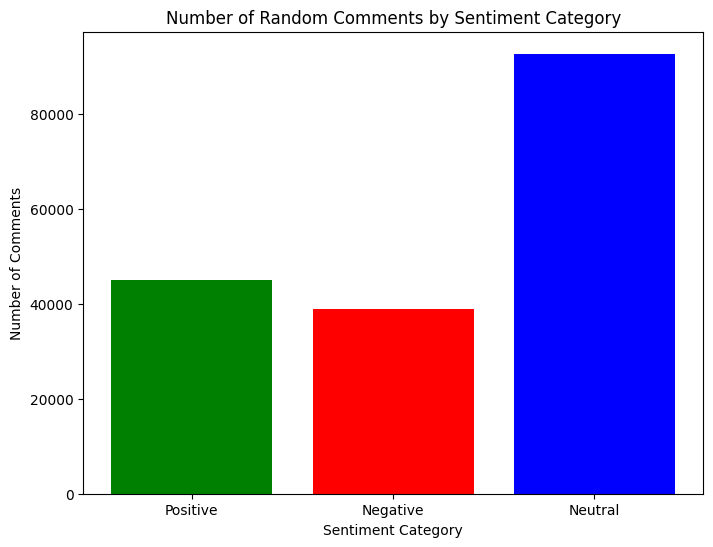

In [191]:
def get_comment_by_label(data, category):
    comments = data[data['sentiment_label'] == category]['komentar']
    return comments.tolist()

positive_comments = get_comment_by_label(cleaned_copy, 'Positif')
negative_comments = get_comment_by_label(cleaned_copy, 'Negatif')
neutral_comments = get_comment_by_label(cleaned_copy, 'Netral')

comment_counts = {
    'Positive': len(positive_comments),
    'Negative': len(negative_comments),
    'Neutral': len(neutral_comments)
}

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(comment_counts.keys(), comment_counts.values(), color=['green', 'red', 'blue'])

# Add title and labels
plt.title('Number of Random Comments by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')

# Show the plot
plt.show()


<Figure size 1500x800 with 0 Axes>

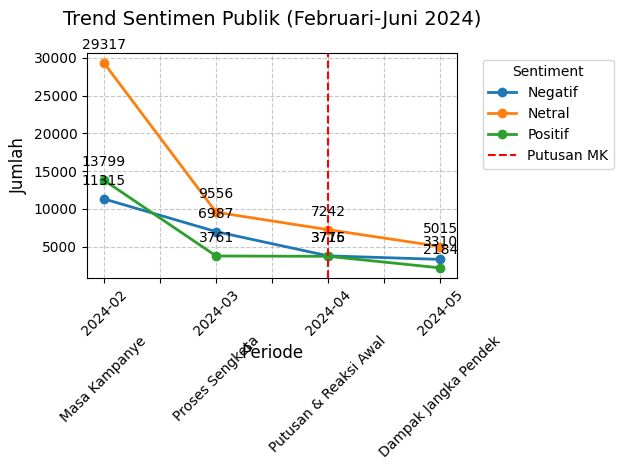


Jumlah Sentimen per Bulan:
sentiment_label  Negatif  Netral  Positif
month                                    
2024-02            11315   29317    13799
2024-03             6987    9556     3761
2024-04             3776    7242     3715
2024-05             3310    5015     2184

Jumlah Sentimen Minggu Putusan MK (4-11 April 2024):
sentiment_label  Negatif  Netral  Positif
week                                     
2024-14              924    1749      814
2024-15              281     474      222


In [192]:
# Konversi timestamp_video ke datetime
cleaned_copy['timestamp_video'] = pd.to_datetime(cleaned_copy['timestamp_video'])

# Membuat kolom bulan dan minggu
cleaned_copy['month'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%m')
cleaned_copy['week'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%W')

# Filter data untuk periode Februari-Juni 2024
mask = (cleaned_copy['timestamp_video'] >= '2024-02-01') & (cleaned_copy['timestamp_video'] <= '2024-06-30')
filtered_data = cleaned_copy[mask]

# Analisis per bulan
sentiment_by_month = filtered_data.groupby(['month'])['sentiment_label'].value_counts().unstack()

# Analisis khusus untuk minggu putusan MK (4-11 April 2024)
mask_mk_week = (filtered_data['timestamp_video'] >= '2024-04-04') & (filtered_data['timestamp_video'] <= '2024-04-11')
mk_week_data = filtered_data[mask_mk_week]
sentiment_mk_week = mk_week_data.groupby(['week'])['sentiment_label'].value_counts().unstack()

# Plot data bulanan
plt.figure(figsize=(15, 8))

# Plot utama
ax = sentiment_by_month.plot(kind='line', marker='o', linewidth=2)

# Menambahkan anotasi untuk setiap titik data
for column in sentiment_by_month.columns:
    for idx, value in sentiment_by_month[column].items():
        plt.annotate(f'{int(value)}', 
                    (sentiment_by_month.index.get_loc(idx), value),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Menambahkan garis vertikal untuk menandai putusan MK
plt.axvline(x=sentiment_by_month.index.get_loc('2024-04'), color='r', linestyle='--', label='Putusan MK')

# Mempercantik grafik
plt.title('Trend Sentimen Publik (Februari-Juni 2024)', fontsize=14, pad=20)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Menambahkan anotasi periode
periods = [
    ('2024-02', 'Masa Kampanye'),
    ('2024-03', 'Proses Sengketa'),
    ('2024-04', 'Putusan & Reaksi Awal'),
    ('2024-05', 'Dampak Jangka Pendek'),
    ('2024-06', 'Dampak Jangka Menengah')
]

for i, (month, label) in enumerate(periods):
    plt.annotate(label, 
                (i, plt.ylim()[0]),
                xytext=(0, -40),
                textcoords='offset points',
                ha='center',
                va='top',
                rotation=45,
                fontsize=10)

plt.tight_layout()
plt.show()

# Menampilkan tabel data bulanan
print("\nJumlah Sentimen per Bulan:")
print(sentiment_by_month)

# Menampilkan tabel data minggu putusan MK
print("\nJumlah Sentimen Minggu Putusan MK (4-11 April 2024):")
print(sentiment_mk_week)


### Sentiment analysis dengan menggunakan dataset Inset

In [193]:

path = f"{os.getcwd()}/dataset/inset_koto/"

cleaned_copy = cleaned_data.copy()
data_as_list = cleaned_copy['komentar'].tolist()
def ekstraksi_sentimen_inset(list_tweet):
    pos = pd.read_csv(path  + "positive_koto.tsv", sep='\t', header=None, names=['word', 'weight'])
    pos_dict = dict(zip(pos['word'], pos['weight']))
    # Read negative sentiment lexicon
    neg = pd.read_csv(path +  "negative_koto.tsv", sep='\t', header=None, names=['word', 'weight'])
    neg_dict = dict(zip(neg['word'], neg['weight']))

    fitur_sentimen_all = []
    sentimen_label = []
    for tweet in list_tweet:
        # inisiasi value
        if pd.isna(tweet) or not isinstance(tweet, str):
        # Jika data bukan string, set sebagai netral
            fitur_sentimen_all.append([0, 0])
            sentimen_label.append("Netral")
            continue

        emosi_value = {}
        emosi_value["positif"] = 0.0
        emosi_value["negatif"] = 0.
        

        list_kata = tweet.split()
        for k in list_kata:
            if k in pos_dict:
                emosi_value["positif"] += float(pos_dict[k])
            if k in neg_dict:
                emosi_value["negatif"] += abs(float(neg_dict[k]))

        fitur_sentimen_perkalimat = list(emosi_value.values())

        if emosi_value["positif"] > emosi_value["negatif"]:
            label = "Positif"
        elif emosi_value["positif"] < emosi_value["negatif"]:
            label = "Negatif"
        else:
            label = "Netral"
        
        sentimen_label.append(label)
        fitur_sentimen_all.append(fitur_sentimen_perkalimat)

    return fitur_sentimen_all, sentimen_label

In [194]:
sentiment_scores, sentiment_labels = ekstraksi_sentimen_inset(data_as_list)

# Menambahkan hasil ke dataframe
cleaned_copy['sentiment_score'] = sentiment_scores
cleaned_copy['sentiment_label'] = sentiment_labels

# Melihat hasilnya
print(cleaned_copy[['komentar', 'sentiment_label']].head())


                                            komentar sentiment_label
0                 buka jalan anak muda kepala daerah         Negatif
1                       memang ngrbmlk klarga gtauml         Positif
2                                       putra sulung          Netral
3  batas usia 20th anak mudah pimpin buka lebar b...         Negatif
4                         keluarga hapus allah surga         Positif


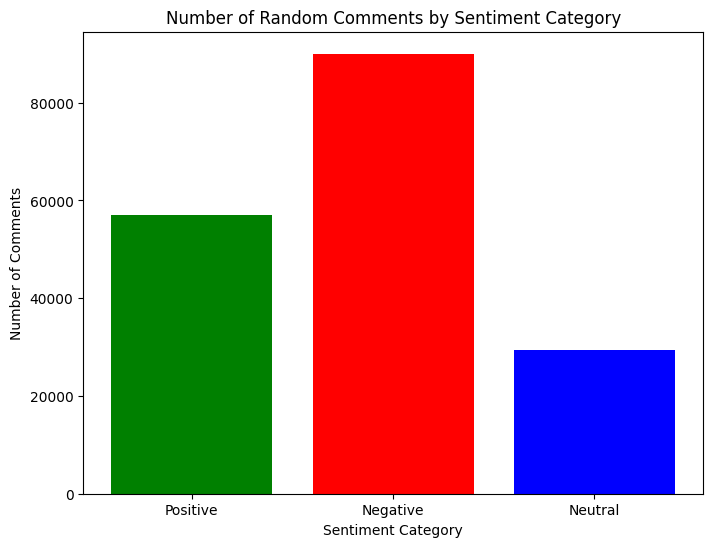

In [195]:
def get_comment_by_label(data, category):
    comments = data[data['sentiment_label'] == category]['komentar']
    return comments.tolist()

positive_comments = get_comment_by_label(cleaned_copy, 'Positif')
negative_comments = get_comment_by_label(cleaned_copy, 'Negatif')
neutral_comments = get_comment_by_label(cleaned_copy, 'Netral')

comment_counts = {
    'Positive': len(positive_comments),
    'Negative': len(negative_comments),
    'Neutral': len(neutral_comments)
}

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(comment_counts.keys(), comment_counts.values(), color=['green', 'red', 'blue'])

# Add title and labels
plt.title('Number of Random Comments by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')

# Show the plot
plt.show()


<Figure size 1500x800 with 0 Axes>

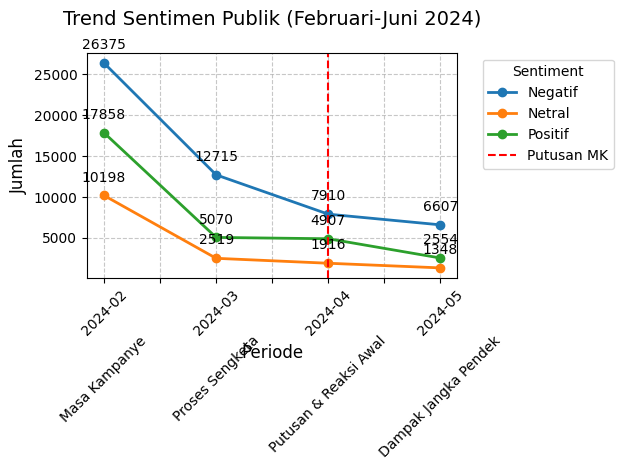


Jumlah Sentimen per Bulan:
sentiment_label  Negatif  Netral  Positif
month                                    
2024-02            26375   10198    17858
2024-03            12715    2519     5070
2024-04             7910    1916     4907
2024-05             6607    1348     2554

Jumlah Sentimen Minggu Putusan MK (4-11 April 2024):
sentiment_label  Negatif  Netral  Positif
week                                     
2024-14             1961     438     1088
2024-15              544     120      313


In [196]:
# Konversi timestamp_video ke datetime
cleaned_copy['timestamp_video'] = pd.to_datetime(cleaned_copy['timestamp_video'])

# Membuat kolom bulan dan minggu
cleaned_copy['month'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%m')
cleaned_copy['week'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%W')

# Filter data untuk periode Februari-Juni 2024
mask = (cleaned_copy['timestamp_video'] >= '2024-02-01') & (cleaned_copy['timestamp_video'] <= '2024-06-30')
filtered_data = cleaned_copy[mask]

# Analisis per bulan
sentiment_by_month = filtered_data.groupby(['month'])['sentiment_label'].value_counts().unstack()

# Analisis khusus untuk minggu putusan MK (4-11 April 2024)
mask_mk_week = (filtered_data['timestamp_video'] >= '2024-04-04') & (filtered_data['timestamp_video'] <= '2024-04-11')
mk_week_data = filtered_data[mask_mk_week]
sentiment_mk_week = mk_week_data.groupby(['week'])['sentiment_label'].value_counts().unstack()

# Plot data bulanan
plt.figure(figsize=(15, 8))

# Plot utama
ax = sentiment_by_month.plot(kind='line', marker='o', linewidth=2)

# Menambahkan anotasi untuk setiap titik data
for column in sentiment_by_month.columns:
    for idx, value in sentiment_by_month[column].items():
        plt.annotate(f'{int(value)}', 
                    (sentiment_by_month.index.get_loc(idx), value),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Menambahkan garis vertikal untuk menandai putusan MK
plt.axvline(x=sentiment_by_month.index.get_loc('2024-04'), color='r', linestyle='--', label='Putusan MK')

# Mempercantik grafik
plt.title('Trend Sentimen Publik (Februari-Juni 2024)', fontsize=14, pad=20)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Menambahkan anotasi periode
periods = [
    ('2024-02', 'Masa Kampanye'),
    ('2024-03', 'Proses Sengketa'),
    ('2024-04', 'Putusan & Reaksi Awal'),
    ('2024-05', 'Dampak Jangka Pendek'),
    ('2024-06', 'Dampak Jangka Menengah')
]

for i, (month, label) in enumerate(periods):
    plt.annotate(label, 
                (i, plt.ylim()[0]),
                xytext=(0, -40),
                textcoords='offset points',
                ha='center',
                va='top',
                rotation=45,
                fontsize=10)

plt.tight_layout()
plt.show()

# Menampilkan tabel data bulanan
print("\nJumlah Sentimen per Bulan:")
print(sentiment_by_month)

# Menampilkan tabel data minggu putusan MK
print("\nJumlah Sentimen Minggu Putusan MK (4-11 April 2024):")
print(sentiment_mk_week)


### Sentiment Anaysis dengan menggunakan id sentiment lexicon

In [197]:

path = f"{os.getcwd()}/dataset"
cleaned_copy = cleaned_data.copy()
def ekstraksi_sentimen_id_sentimen_lexicon(list_tweet):
    word_list = pd.read_csv(path + "/id_sentiment_lexicon/" + "id_sentiment_lexicon.txt", header=None,  sep='\t', names=['word', "weight"])
    word_dict = dict(zip(word_list['word'], word_list['weight']))
    fitur_sentimen_all = []
    sentiment_label = []
    for tweet in list_tweet:
        # inisiasi value
        if pd.isna(tweet) or not isinstance(tweet, str):
            # Jika data bukan string, set sebagai netral
            fitur_sentimen_all.append([0, 0])
            sentiment_label.append("Netral")
            continue
        
        emosi_value = {}
        emosi_value["positif"] = 0
        emosi_value["negatif"] = 0

        list_kata = tweet.split()
        for k in list_kata:
            if k in word_dict:
                if float(word_dict[k]) > 0:
                    emosi_value["positif"] += float(word_dict[k])
                else:
                    emosi_value["negatif"] += abs(float(word_dict[k]))
           

        fitur_sentimen_perkalimat = list(emosi_value.values())
        emosi_value.items()
        if emosi_value["positif"] > emosi_value["negatif"]:
            label = "Positif"
        elif emosi_value["positif"] < emosi_value["negatif"]:
            label = "Negatif"
        else:
            label = "Netral"
        sentiment_label.append(label)
        fitur_sentimen_all.append(fitur_sentimen_perkalimat)

    return fitur_sentimen_all, sentiment_label
    

In [198]:
sentiment_scores, sentiment_labels = ekstraksi_sentimen_id_sentimen_lexicon(data_as_list)

# Menambahkan hasil ke dataframe
cleaned_copy['sentiment_score'] = sentiment_scores
cleaned_copy['sentiment_label'] = sentiment_labels

# Melihat hasilnya
print(cleaned_copy[['komentar', 'sentiment_label']].head())


                                            komentar sentiment_label
0                 buka jalan anak muda kepala daerah         Positif
1                       memang ngrbmlk klarga gtauml          Netral
2                                       putra sulung          Netral
3  batas usia 20th anak mudah pimpin buka lebar b...         Negatif
4                         keluarga hapus allah surga         Positif


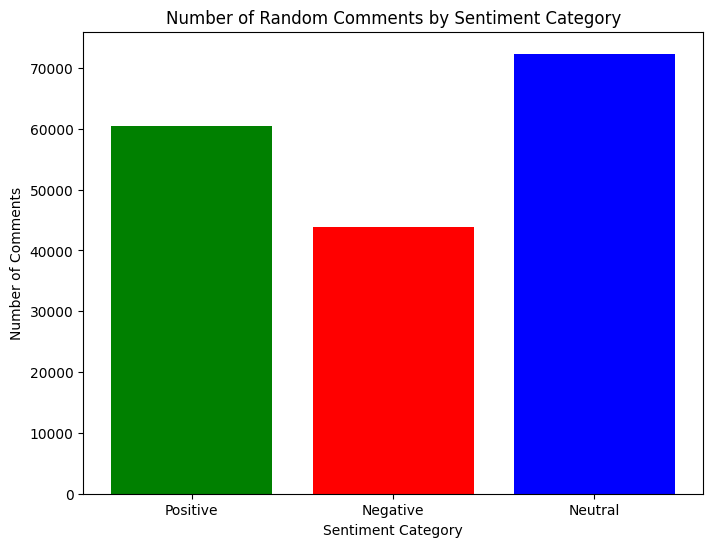

In [199]:
def get_comment_by_label(data, category):
    comments = data[data['sentiment_label'] == category]['komentar']
    return comments.tolist()

positive_comments = get_comment_by_label(cleaned_copy, 'Positif')
negative_comments = get_comment_by_label(cleaned_copy, 'Negatif')
neutral_comments = get_comment_by_label(cleaned_copy, 'Netral')

comment_counts = {
    'Positive': len(positive_comments),
    'Negative': len(negative_comments),
    'Neutral': len(neutral_comments)
}

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(comment_counts.keys(), comment_counts.values(), color=['green', 'red', 'blue'])

# Add title and labels
plt.title('Number of Random Comments by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')

# Show the plot
plt.show()


<Figure size 1500x800 with 0 Axes>

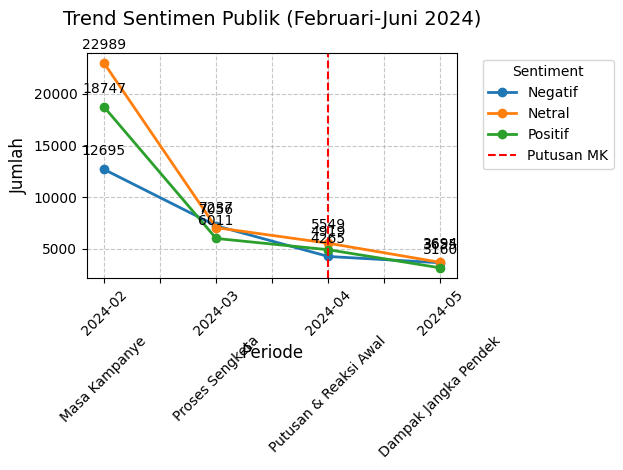


Jumlah Sentimen per Bulan:
sentiment_label  Negatif  Netral  Positif
month                                    
2024-02            12695   22989    18747
2024-03             7237    7056     6011
2024-04             4265    5549     4919
2024-05             3655    3694     3160

Jumlah Sentimen Minggu Putusan MK (4-11 April 2024):
sentiment_label  Negatif  Netral  Positif
week                                     
2024-14             1021    1364     1102
2024-15              321     338      318


In [200]:
# Konversi timestamp_video ke datetime
cleaned_copy['timestamp_video'] = pd.to_datetime(cleaned_copy['timestamp_video'])

# Membuat kolom bulan dan minggu
cleaned_copy['month'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%m')
cleaned_copy['week'] = cleaned_copy['timestamp_video'].dt.strftime('%Y-%W')

# Filter data untuk periode Februari-Juni 2024
mask = (cleaned_copy['timestamp_video'] >= '2024-02-01') & (cleaned_copy['timestamp_video'] <= '2024-06-30')
filtered_data = cleaned_copy[mask]

# Analisis per bulan
sentiment_by_month = filtered_data.groupby(['month'])['sentiment_label'].value_counts().unstack()

# Analisis khusus untuk minggu putusan MK (4-11 April 2024)
mask_mk_week = (filtered_data['timestamp_video'] >= '2024-04-04') & (filtered_data['timestamp_video'] <= '2024-04-11')
mk_week_data = filtered_data[mask_mk_week]
sentiment_mk_week = mk_week_data.groupby(['week'])['sentiment_label'].value_counts().unstack()

# Plot data bulanan
plt.figure(figsize=(15, 8))

# Plot utama
ax = sentiment_by_month.plot(kind='line', marker='o', linewidth=2)

# Menambahkan anotasi untuk setiap titik data
for column in sentiment_by_month.columns:
    for idx, value in sentiment_by_month[column].items():
        plt.annotate(f'{int(value)}', 
                    (sentiment_by_month.index.get_loc(idx), value),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Menambahkan garis vertikal untuk menandai putusan MK
plt.axvline(x=sentiment_by_month.index.get_loc('2024-04'), color='r', linestyle='--', label='Putusan MK')

# Mempercantik grafik
plt.title('Trend Sentimen Publik (Februari-Juni 2024)', fontsize=14, pad=20)
plt.xlabel('Periode', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Menambahkan anotasi periode
periods = [
    ('2024-02', 'Masa Kampanye'),
    ('2024-03', 'Proses Sengketa'),
    ('2024-04', 'Putusan & Reaksi Awal'),
    ('2024-05', 'Dampak Jangka Pendek'),
    ('2024-06', 'Dampak Jangka Menengah')
]

for i, (month, label) in enumerate(periods):
    plt.annotate(label, 
                (i, plt.ylim()[0]),
                xytext=(0, -40),
                textcoords='offset points',
                ha='center',
                va='top',
                rotation=45,
                fontsize=10)

plt.tight_layout()
plt.show()

# Menampilkan tabel data bulanan
print("\nJumlah Sentimen per Bulan:")
print(sentiment_by_month)

# Menampilkan tabel data minggu putusan MK
print("\nJumlah Sentimen Minggu Putusan MK (4-11 April 2024):")
print(sentiment_mk_week)


### Ekstrasi Sentiment dengan menggunakan K-means Clustering

In [201]:
# Import library
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Contoh data
texts = cleaned_data.dropna(subset=['komentar'])['komentar'].tolist()

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X)

# Analisis hasil
df = pd.DataFrame({
    'text': texts,
    'cluster': clusters
})



c:\Users\User\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [202]:
# Import library tambahan
from collections import Counter
import numpy as np

# Lihat kata dominan tiap cluster
for i in range(10):
    print(f"\nCluster {i}:")
    cluster_texts = df[df['cluster'] == i]['text']
    
    # Gabungkan semua teks dalam cluster
    combined_texts = ' '.join(cluster_texts)
    
    # Ubah jadi list kata-kata
    words = combined_texts.split()
    
    # Hitung frekuensi kata
    word_freq = Counter(words)
    
    # Ambil 10 kata teratas
    top_words = word_freq.most_common(10)
    
    print("Kata-kata yang paling sering muncul:")
    for word, freq in top_words:
        print(f"- {word}: {freq}")

# Visualisasi proporsi cluster
cluster_sizes = df['cluster'].value_counts()



Cluster 0:
Kata-kata yang paling sering muncul:
- prabowo: 12847
- gibran: 8231
- jokowi: 2342
- mas: 2211
- menang: 2023
- pilih: 1608
- indonesia: 1396
- dukung: 1288
- presiden: 1215
- semoga: 1093

Cluster 1:
Kata-kata yang paling sering muncul:
- indonesia: 9358
- negara: 7676
- republik: 2660
- kesatuan: 2084
- rakyat: 1884
- jokowi: 1799
- pimpin: 1713
- maju: 1528
- bangsa: 1385
- presiden: 1381

Cluster 2:
Kata-kata yang paling sering muncul:
- jokowi: 12031
- tidak: 6055
- anak: 4998
- kalah: 4822
- indonesia: 4381
- sudah: 4358
- menang: 4246
- banget: 4210
- bicara: 3979
- ganjar: 3881

Cluster 3:
Kata-kata yang paling sering muncul:
- presiden: 13448
- calon: 5897
- wakil: 3597
- jokowi: 2277
- prabowo: 2201
- gibran: 1549
- pilih: 1519
- indonesia: 1426
- pemilihan: 1101
- rakyat: 973

Cluster 4:
Kata-kata yang paling sering muncul:
- partai: 14800
- indonesia: 11519
- demokrasi: 11007
- perjuangan: 8118
- jokowi: 6215
- presiden: 1787
- rakyat: 1600
- p: 1232
- ganjar: 

## Topic Modelling

### Menggunakan metode Non-Negative Matrix Factorization (NMF) 


In [204]:

# # Memuat data dari file CSV
# df = pd.read_csv('csv_data/cleaned_data.csv')
# df.columns = ['komentar', 'timestamp_video', 'timestamp_komentar']
# df['komentar'] = df['komentar'].astype(str)

# # Hapus baris dengan komentar kosong
# df = df.dropna(subset=['komentar'])

# # Tampilkan 5 baris pertama untuk verifikasi
# print(df.head())
df = cleaned_data.copy()

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,  # Batasi jumlah fitur untuk efisiensi
    norm='l1'
)

tfidf_matrix = vectorizer.fit_transform(df['komentar'])

# Cek dimensi matriks
print("Dimensi matriks TF-IDF:", tfidf_matrix.shape)


Dimensi matriks TF-IDF: (176588, 1000)


In [206]:
from sklearn.decomposition import NMF

# Jumlah topik
num_topics = 6

# Model NMF
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Menampilkan kata-kata utama di setiap topik
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topik {topic_idx}:")
    print([feature_names[i] for i in topic.argsort()[-10:]])


Topik 0:
['all', 'ganjar', 'semoga', 'putar', 'mantap', 'dukung', 'pilih', 'presiden', 'menang', 'prabowo']
Topik 1:
['kuasa', 'turun', 'jahat', 'politik', 'partai', 'hebat', 'mantap', 'dukung', 'keluarga', 'jokowi']
Topik 2:
['lagu', 'menang', 'putar', 'torang', 'nomor', 'mantap', 'no', '02', 'oke', 'gas']
Topik 3:
['pilih', 'maju', 'bicara', 'wakil', 'putar', 'anak', 'mantap', 'kayak', 'mas', 'gibran']
Topik 4:
['suka', 'lucu', 'sumpah', 'bagus', 'bang', 'gila', 'lagu', 'mantap', 'banget', 'keren']
Topik 5:
['tidak', 'perjuangan', 'pilih', 'kalah', 'demokrasi', 'rakyat', 'presiden', 'partai', 'orang', 'indonesia']


In [207]:
# Transformasi TF-IDF ke distribusi topik
topic_distribution = nmf_model.transform(tfidf_matrix)

# Tentukan topik dominan untuk setiap komentar
df['topik_dominan'] = topic_distribution.argmax(axis=1)

# Tampilkan komentar dan topik dominannya
print(df[['komentar', 'topik_dominan']].head())

                                            komentar  topik_dominan
0                 buka jalan anak muda kepala daerah              5
1                       memang ngrbmlk klarga gtauml              5
2                                       putra sulung              0
3  batas usia 20th anak mudah pimpin buka lebar b...              5
4                         keluarga hapus allah surga              5


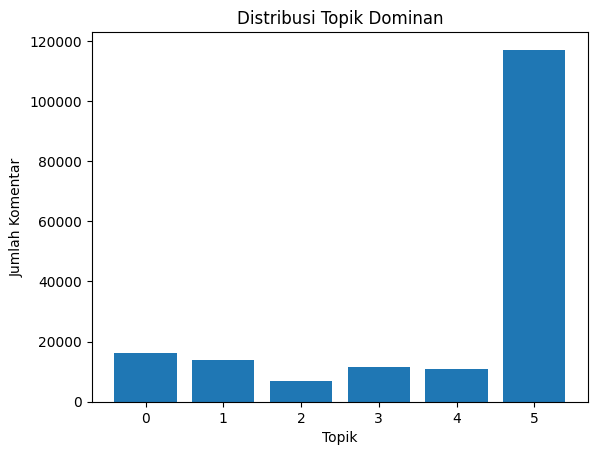

In [208]:
import matplotlib.pyplot as plt

plt.hist(df['topik_dominan'], bins=range(num_topics+1), align='left', rwidth=0.8)
plt.xlabel('Topik')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi Topik Dominan')
plt.show()

In [210]:
import pandas as pd
from datetime import datetime

df['timestamp_komentar'] = pd.to_datetime(df['timestamp_komentar'], errors='coerce')

# Ubah kolom timestamp_komentar menjadi format datetime
df['timestamp_komentar'] = df['timestamp_komentar'].dt.tz_localize(None)


# Tentukan rentang waktu
before_voting_day = df[df['timestamp_komentar'] < datetime(2024, 2, 14)]
between_voting_and_decision = df[
    (df['timestamp_komentar'] >= datetime(2024, 2, 14)) &
    (df['timestamp_komentar'] <= datetime(2024, 4, 24))
]
after_decision = df[df['timestamp_komentar'] > datetime(2024, 4, 24)]

# Verifikasi pembagian
print("Komentar sebelum hari pencoblosan:", before_voting_day.shape[0])
print("Komentar antara pencoblosan dan penetapan:", between_voting_and_decision.shape[0])
print("Komentar setelah penetapan:", after_decision.shape[0])


Komentar sebelum hari pencoblosan: 66438
Komentar antara pencoblosan dan penetapan: 79737
Komentar setelah penetapan: 30413


In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

def run_topic_modeling(data, num_topics=6):
    # Vectorizer
    vectorizer = TfidfVectorizer(max_features=1000, norm='l1')
    tfidf_matrix = vectorizer.fit_transform(data['komentar'])
    
    # Model NMF
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf_matrix)
    
    # Tampilkan topik
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topik {topic_idx}:")
        print([feature_names[i] for i in topic.argsort()[-10:]])
    
    # Distribusi topik
    topic_distribution = nmf_model.transform(tfidf_matrix)
    data['topik_dominan'] = topic_distribution.argmax(axis=1)
    
    # Visualisasi distribusi topik
    plt.hist(data['topik_dominan'], bins=range(num_topics+1), align='left', rwidth=0.8)
    plt.xlabel('Topik')
    plt.ylabel('Jumlah Komentar')
    plt.title('Distribusi Topik Dominan')
    plt.show()


=== Topik Sebelum Hari Pencoblosan ===
Topik 0:
['presiden', 'subianto', '2024', 'pilih', 'putar', 'dukung', 'in', 'all', 'menang', 'prabowo']
Topik 1:
['nomer', 'pas', 'pol', 'tren', 'putar', 'torang', 'nomor', 'no', 'oke', 'gas']
Topik 2:
['mantap', 'anak', 'banget', 'menang', 'keren', 'maju', 'bicara', 'putar', 'mas', 'gibran']
Topik 3:
['sudah', 'anak', 'keluarga', 'demokrasi', 'dukung', 'indonesia', 'orang', 'partai', 'rakyat', 'jokowi']
Topik 4:
['rakyat', 'wakil', 'orang', 'semoga', 'anis', 'indonesia', 'calon', 'pilih', 'presiden', 'amin']
Topik 5:
['banget', 'hadir', 'in', 'all', 'lagu', 'putar', 'keren', 'menang', 'mantap', '02']


C:\Users\User\AppData\Local\Temp\ipykernel_27068\345655967.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['topik_dominan'] = topic_distribution.argmax(axis=1)


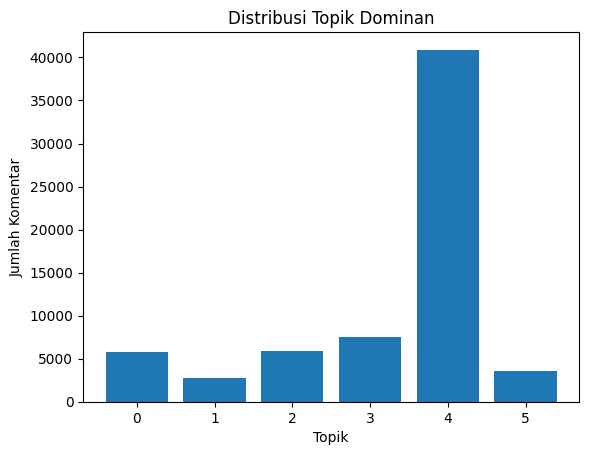

=== Topik Antara Pencoblosan dan Penetapan ===
Topik 0:
['dukung', 'keluarga', 'sehat', 'lawan', 'politik', 'jahat', 'mantap', 'hebat', 'presiden', 'jokowi']
Topik 1:
['video', 'rap', 'anjing', 'coy', 'parah', 'bang', 'habis', 'sumpah', 'gila', 'keren']
Topik 2:
['semoga', 'mantap', '02', 'dukung', 'pilih', 'mas', 'presiden', 'menang', 'gibran', 'prabowo']
Topik 3:
['03', 'bicara', '01', 'legowo', 'tidak', 'sudah', 'terima', 'curang', 'menang', 'kalah']
Topik 4:
['ganjar', '02', 'pilih', 'perjuangan', 'presiden', 'rakyat', 'demokrasi', 'orang', 'partai', 'indonesia']
Topik 5:
['lucu', 'sumpah', 'candu', 'suka', 'gila', 'lagu', 'mantap', 'ganjar', 'bagus', 'banget']


C:\Users\User\AppData\Local\Temp\ipykernel_27068\345655967.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['topik_dominan'] = topic_distribution.argmax(axis=1)


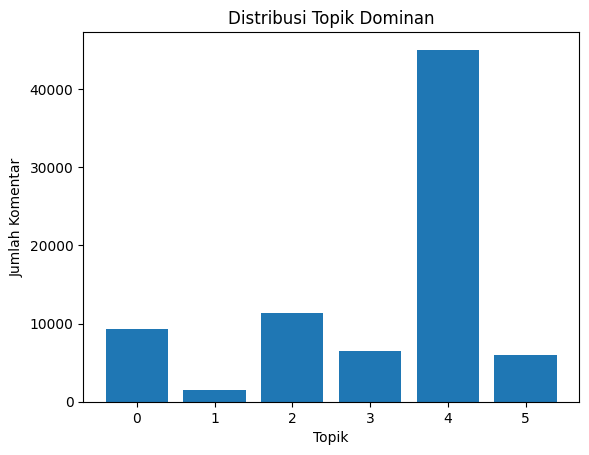

=== Topik Setelah Penetapan ===
Topik 0:
['maju', 'kader', 'sombong', 'negara', 'politik', 'rakyat', 'perjuangan', 'demokrasi', 'partai', 'indonesia']
Topik 1:
['ganjar', 'selamat', 'menang', 'semoga', 'wakil', 'mas', 'pilih', 'presiden', 'gibran', 'prabowo']
Topik 2:
['anak', 'dukung', 'politik', 'mega', 'sehat', 'keluarga', 'hebat', 'rakyat', 'presiden', 'jokowi']
Topik 3:
['suka', 'kayak', 'pintar', 'rocky', 'gerung', 'bicara', 'rakyat', 'tidak', 'irma', 'orang']
Topik 4:
['tidak', 'sok', 'mulut', 'suka', 'omong', 'pintar', 'sombong', 'kerja', 'bicara', 'ahok']
Topik 5:
['sehat', 'bagus', 'adi', 'lucu', 'suara', 'bang', 'keren', 'lagu', 'banget', 'mantap']


C:\Users\User\AppData\Local\Temp\ipykernel_27068\345655967.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['topik_dominan'] = topic_distribution.argmax(axis=1)


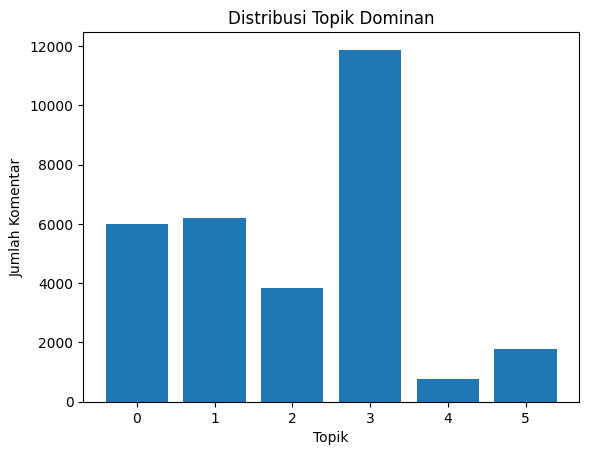

In [212]:
print("=== Topik Sebelum Hari Pencoblosan ===")
run_topic_modeling(before_voting_day)

print("=== Topik Antara Pencoblosan dan Penetapan ===")
run_topic_modeling(between_voting_and_decision)

print("=== Topik Setelah Penetapan ===")
run_topic_modeling(after_decision)
